In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

from transaction_laboratory import transactionLaboratory
from schemes import random_behavior, layering, round_tripping

In [2]:
rb = random_behavior(N = 100)
df_rb = rb.generate(100)
df_rb['behavior'] = rb.behavior_name
df_rb.head(5)


,source,target,amount,time,behavior
0,C95,C52,224.87,2025-03-01 08:00:00,random
1,C25,C64,397.99,2025-03-01 08:00:10,random
2,C26,C16,452.43,2025-03-01 08:00:14,random
3,C13,C39,496.86,2025-03-01 08:00:22,random
4,C42,C10,57.34,2025-03-01 08:00:28,random


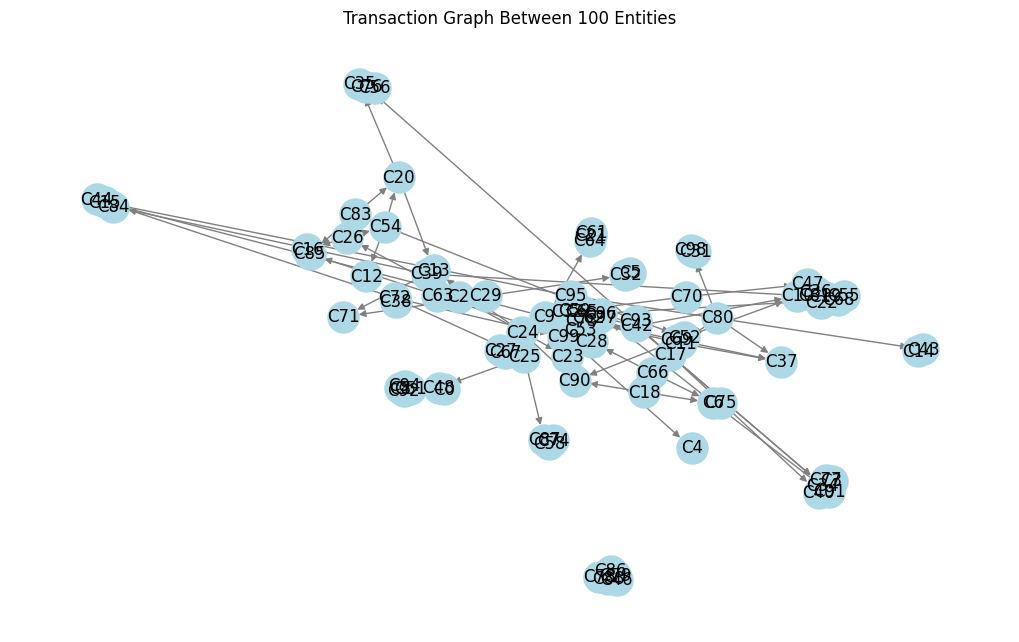

In [3]:
rb.plotTransactionGraph(df_rb, edgeLables=False, title="Transaction Graph Between " + str(rb.N)  + " Entities") #TODO: maybe make this plot animated in time

In [4]:
rt = round_tripping(source_accounts = 10, intermediate_accounts = 30, target_accounts = 4)
df_rt = rt.generate(max_intermediate_transactions = 30)
df_rt['behavior'] = rt.behavior_name
df_rt.head(10)

,source,target,amount,time,behavior
0,S9,I23,275265.89,2025-03-01 08:00:10,round_trip
1,I23,I10,275265.89,2025-03-01 08:00:14,round_trip
2,I10,I12,275265.89,2025-03-01 08:00:21,round_trip
3,I12,I28,275265.89,2025-03-01 08:00:21,round_trip
4,I28,I17,275265.89,2025-03-01 08:00:23,round_trip
5,I17,I0,275265.89,2025-03-01 08:00:27,round_trip
6,I0,I23,275265.89,2025-03-01 08:00:36,round_trip
7,I23,I16,275265.89,2025-03-01 08:00:37,round_trip
8,I16,I19,275265.89,2025-03-01 08:00:45,round_trip
9,I19,I12,275265.89,2025-03-01 08:00:55,round_trip


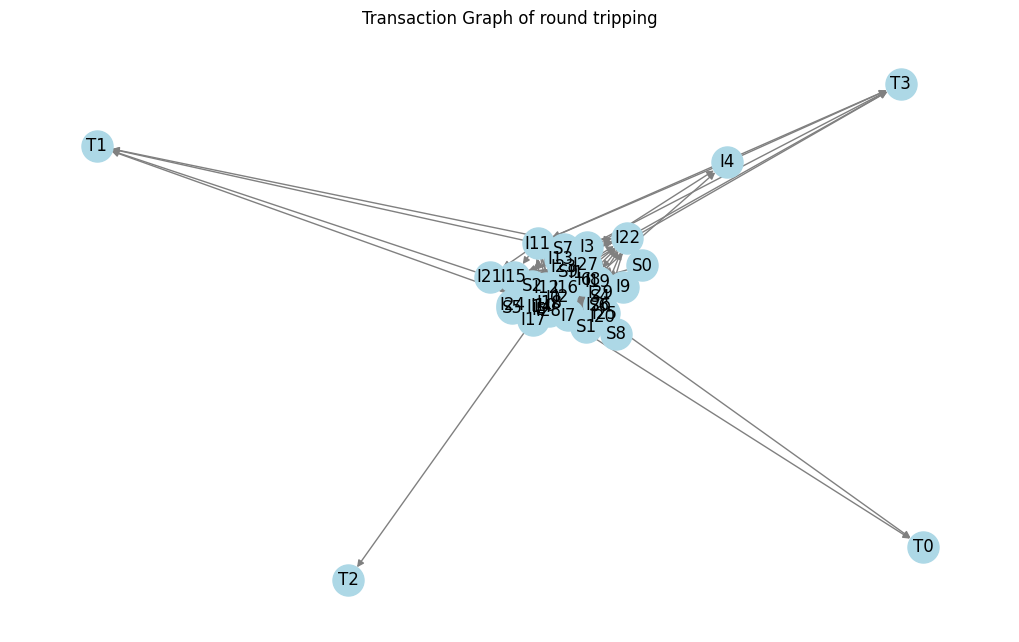

In [5]:
rb.plotTransactionGraph(df_rt, edgeLables=False, title="Transaction Graph of round tripping") #TODO: maybe make this plot animated in time

In [8]:
df = pd.concat([df_rb, df_rt])
df = df.sort_values('time')
print(df.shape)
df.head(10)

(367, 5)


,source,target,amount,time,behavior
0,C95,C52,224.87,2025-03-01 08:00:00,random
118,S2,I13,38828.05,2025-03-01 08:00:01,round_trip
22,S6,I16,482079.08,2025-03-01 08:00:01,round_trip
208,S2,I18,158.73,2025-03-01 08:00:02,round_trip
90,S0,I8,3298.34,2025-03-01 08:00:03,round_trip
91,I8,I6,3298.34,2025-03-01 08:00:03,round_trip
237,S1,I7,12.88,2025-03-01 08:00:03,round_trip
180,S7,I13,1712.41,2025-03-01 08:00:04,round_trip
54,S7,I11,29828.99,2025-03-01 08:00:05,round_trip
119,I13,I10,38828.05,2025-03-01 08:00:05,round_trip
